In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Paramètres pour la connexion à PostgreSQL
host = 'localhost'
port = '5432'
database = 'Sus_DW'
user = 'postgres'
password = '12345678'

# Création du moteur SQLAlchemy
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# Connexion et lecture des tables
with engine.connect() as conn:
    # Correction de la table "fact_performance_environmental" (il manquait un espace)
    df_produits = pd.read_sql("SELECT * FROM dim_produits", conn)
    df_climat = pd.read_sql("SELECT * FROM dim_climat", conn)
    df_equipements = pd.read_sql("SELECT * FROM dim_equipements", conn)
    df_materials = pd.read_sql("SELECT * FROM dim_materials", conn)
    df_notifications = pd.read_sql("SELECT * FROM dim_notifications", conn)
    df_perf_env = pd.read_sql("SELECT * FROM fact_performance_environmental", conn)
    df_maintenance = pd.read_sql("SELECT * FROM fact_maintenance_issues", conn)

# Affichage de l’aperçu de chaque table pour qu’on puisse analyser
print("✅ dim_produits")
print(df_produits.head(), "\n")

print("✅ dim_climat")
print(df_climat.head(), "\n")

print("✅ dim_equipements")
print(df_equipements.head(), "\n")

print("✅ dim_materials")
print(df_materials.head(), "\n")

print("✅ dim_notifications")
print(df_notifications.head(), "\n")

print("✅ fact_performance_environmental")
print(df_perf_env.head(), "\n")

print("✅ fact_maintenance_issues")
print(df_maintenance.head(), "\n")


✅ dim_produits
   Produit_PK          Nom_du_Produit                   Marque  \
0           1                   Perly                   Jaouda   
1           2    Fromage blanc nature  MILKY FOOD PROFESSIONAL   
2           3                    Jben                   Jaouda   
3           4            Perly nature                   Jaouda   
4           5  70% Cacao noir intense                    Lindt   

                                           Categorie energie__kcal  \
0  Produits laitiers/ Produits fermentes/ Dessert...          97.0   
1  Dairies/ Fermented foods/ Fermented milk produ...          80.6   
2  en:Dairies/ en:Fermented foods/ en:Fermented m...         235.0   
3  Dairies/ Fermented foods/ Fermented milk produ...         101.0   
4  Snacks/Snacks sucres/Cacao et derives/Chocolat...         566.0   

  Matieres_grasses__g Proteines__g Sucres__g Empreinte_Carbone__COe_g  
0                 3.0          8.0       9.4              2.107355801  
1                12.0  

In [2]:
# ---------------------------
# 📌 Chargement et prétraitement des données
# ---------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Connexion à PostgreSQL
equipements_df = pd.read_sql("SELECT * FROM dim_equipements", engine)
notifications_df = pd.read_sql("SELECT * FROM dim_notifications", engine)

# Nettoyage initial
equipements_df = equipements_df.dropna(subset=['Equipment_ID'])
notifications_df = notifications_df.dropna(subset=['Equipement_id', 'Priorite'])

# Création du label binaire
notif_critiques = notifications_df[notifications_df['Priorite'] == 'Critique'].copy()
notif_critiques.loc[:, 'label'] = 1
labels = notif_critiques.groupby('Equipement_id')['label'].max().reset_index()

# Fusion des données
dataset = pd.merge(equipements_df, labels, left_on='Equipment_ID', right_on='Equipement_id', how='left')
dataset['label'] = dataset['label'].fillna(0)
dataset = dataset.drop(columns=['Equipement_id'])

# Colonnes sélectionnées
features = ['Manufacturer', 'Energy_Type', 'Estimated_Lifetime_Years', 'CO2_Emissions_kg', 'Energy_Consumption_kWh']
df_model = dataset[features + ['label']].copy()

# Encodage des variables catégorielles
for col in ['Manufacturer', 'Energy_Type']:
    df_model[col] = df_model[col].astype(str)
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

# Conversion des colonnes numériques
for col in ['Estimated_Lifetime_Years', 'CO2_Emissions_kg', 'Energy_Consumption_kWh']:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Séparer features et cible
X = df_model.drop(columns=['label'])
y = df_model['label']

# Imputation complète (numériques + encodées)
X = X.dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
    # ---------------------------
    # 📌 1. K-Nearest Neighbors
    # ---------------------------
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    print("\n🔹 KNN Report:\n", classification_report(y_test, y_pred_knn))


🔹 KNN Report:
               precision    recall  f1-score   support

         0.0       0.46      0.36      0.41        99
         1.0       0.63      0.72      0.67       149

    accuracy                           0.58       248
   macro avg       0.55      0.54      0.54       248
weighted avg       0.56      0.58      0.57       248



In [4]:


# ---------------------------
# 📌 2. Support Vector Machine
# ---------------------------
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
print("\n🔹 SVM Report:\n", classification_report(y_test, y_pred_svm))


🔹 SVM Report:
               precision    recall  f1-score   support

         0.0       0.46      0.16      0.24        99
         1.0       0.61      0.87      0.72       149

    accuracy                           0.59       248
   macro avg       0.53      0.52      0.48       248
weighted avg       0.55      0.59      0.53       248



In [5]:

# ---------------------------
# 📌 3. Decision Tree
# ---------------------------
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree.fit(X_train, y_train)  # pas besoin de scaling
y_pred_tree = dtree.predict(X_test)
print("\n🔹 Decision Tree Report:\n", classification_report(y_test, y_pred_tree))


🔹 Decision Tree Report:
               precision    recall  f1-score   support

         0.0       0.54      0.15      0.24        99
         1.0       0.62      0.91      0.74       149

    accuracy                           0.61       248
   macro avg       0.58      0.53      0.49       248
weighted avg       0.59      0.61      0.54       248



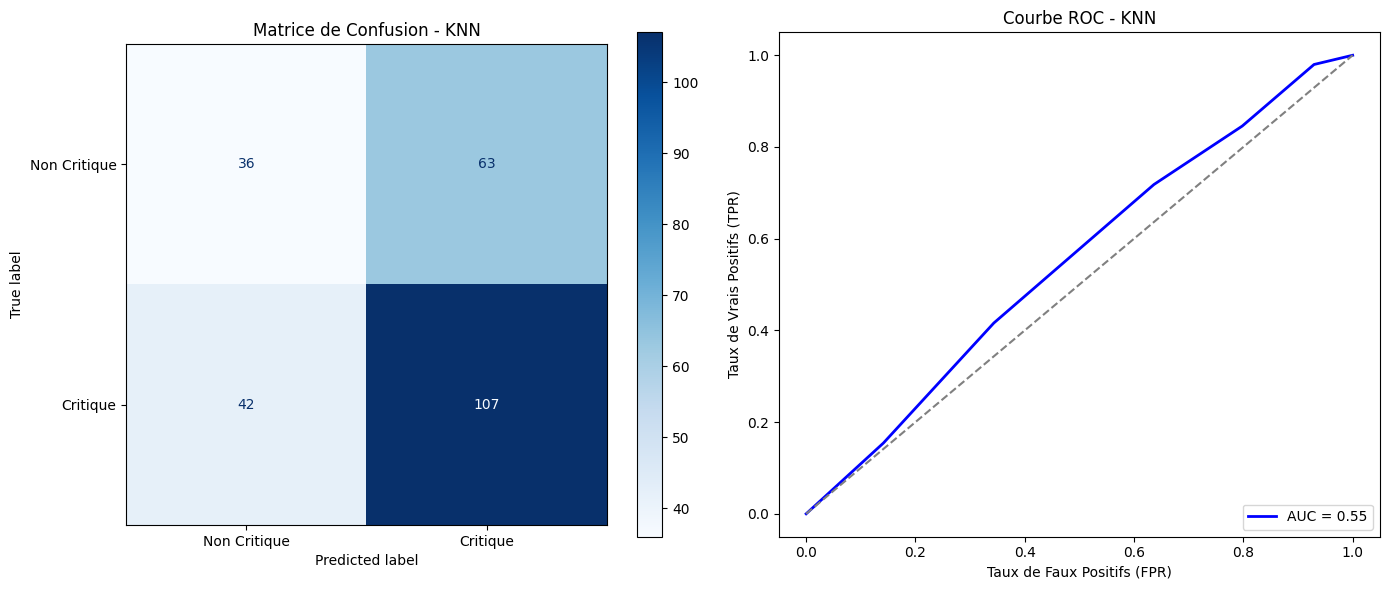

In [6]:
    # 📌 Matrice de confusion et courbe ROC pour KNN
    # ---------------------------
    
    # Matrice de confusion pour KNN
    conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot matrice de confusion
    ConfusionMatrixDisplay(conf_matrix_knn, display_labels=['Non Critique', 'Critique']).plot(cmap='Blues', ax=ax[0])
    ax[0].set_title('Matrice de Confusion - KNN')
    
    # Courbe ROC pour KNN
    fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    
    ax[1].plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'AUC = {roc_auc_knn:.2f}')
    ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[1].set_title('Courbe ROC - KNN')
    ax[1].set_xlabel('Taux de Faux Positifs (FPR)')
    ax[1].set_ylabel('Taux de Vrais Positifs (TPR)')
    ax[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()


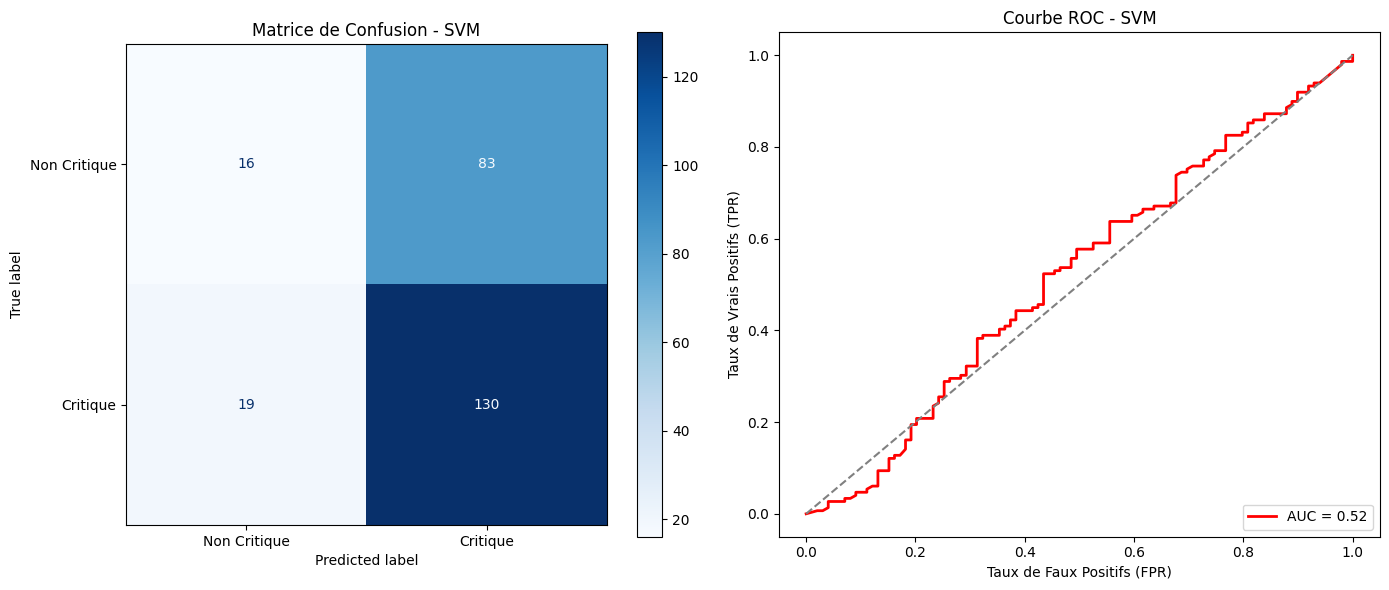

In [7]:
# 📌 Matrice de confusion et courbe ROC pour SVM
# ---------------------------

# Matrice de confusion pour SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot matrice de confusion
ConfusionMatrixDisplay(conf_matrix_svm, display_labels=['Non Critique', 'Critique']).plot(cmap='Blues', ax=ax[0])
ax[0].set_title('Matrice de Confusion - SVM')

# Courbe ROC pour SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.predict_proba(X_test_scaled)[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

ax[1].plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'AUC = {roc_auc_svm:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('Courbe ROC - SVM')
ax[1].set_xlabel('Taux de Faux Positifs (FPR)')
ax[1].set_ylabel('Taux de Vrais Positifs (TPR)')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

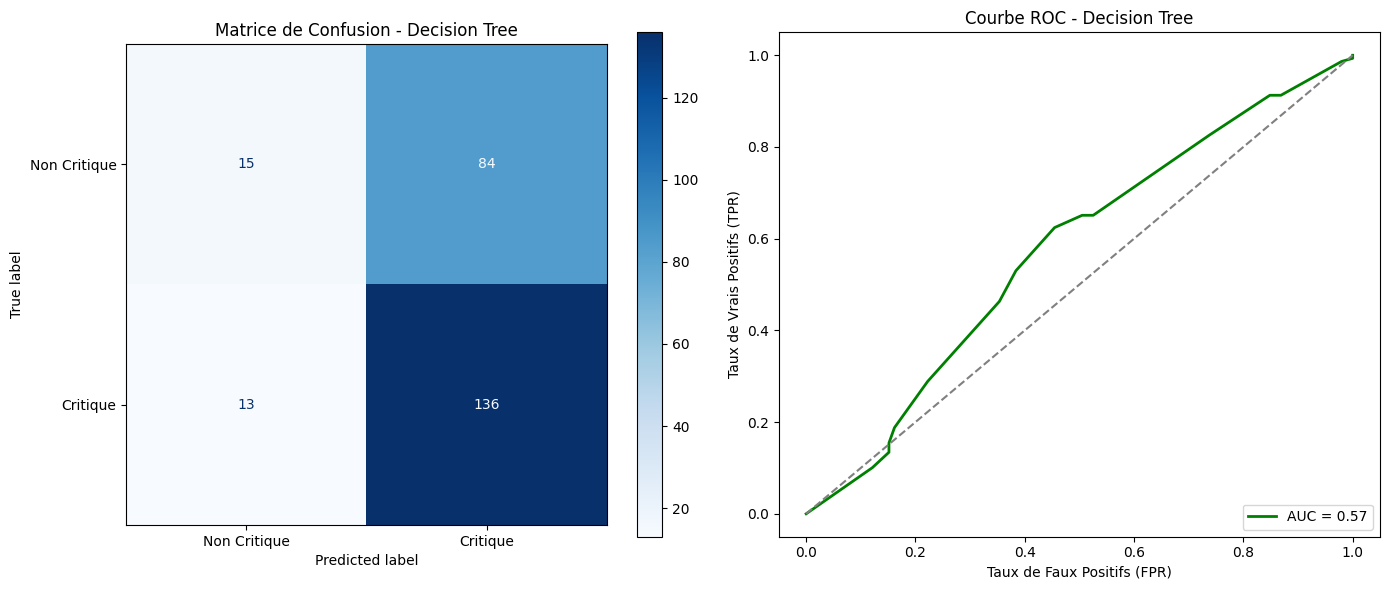

In [8]:
# ---------------------------
# 📌 Matrice de confusion et courbe ROC pour Decision Tree
# ---------------------------

# Matrice de confusion pour Decision Tree
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot matrice de confusion
ConfusionMatrixDisplay(conf_matrix_tree, display_labels=['Non Critique', 'Critique']).plot(cmap='Blues', ax=ax[0])
ax[0].set_title('Matrice de Confusion - Decision Tree')

# Courbe ROC pour Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, dtree.predict_proba(X_test)[:, 1])
roc_auc_tree = auc(fpr_tree, tpr_tree)

ax[1].plot(fpr_tree, tpr_tree, color='green', lw=2, label=f'AUC = {roc_auc_tree:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('Courbe ROC - Decision Tree')
ax[1].set_xlabel('Taux de Faux Positifs (FPR)')
ax[1].set_ylabel('Taux de Vrais Positifs (TPR)')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


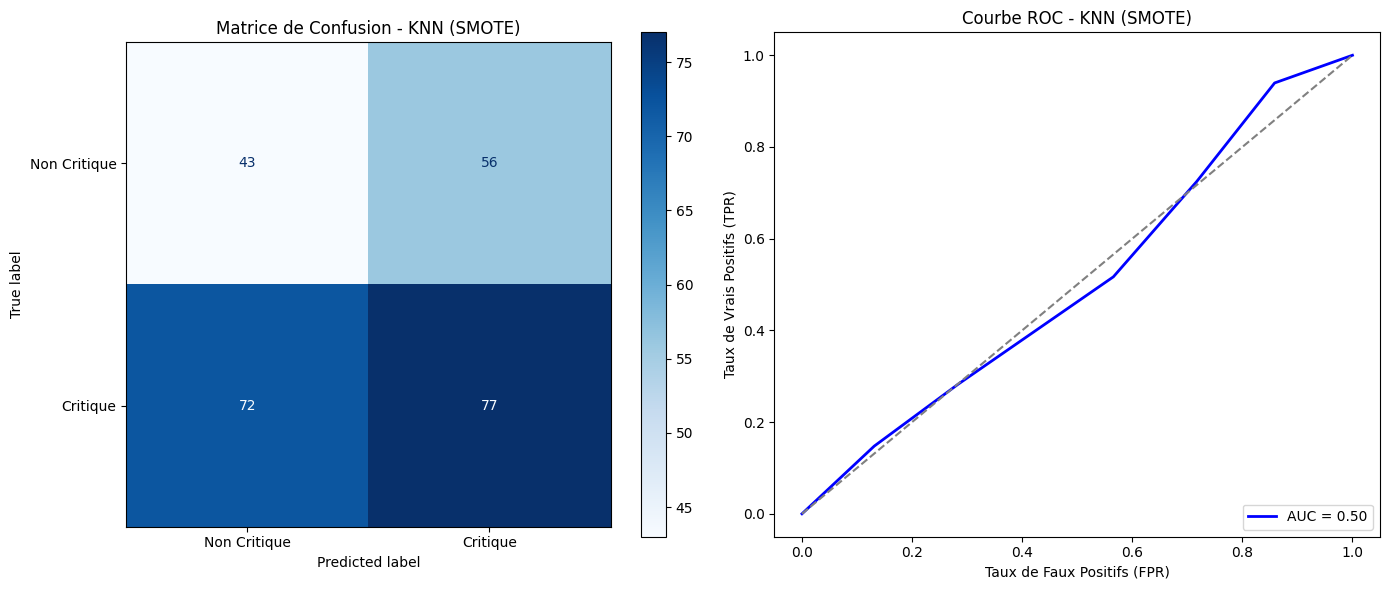

In [14]:
# 📌 Matrice de confusion et courbe ROC pour KNN (après SMOTE)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn_resampled)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Matrice de confusion
ConfusionMatrixDisplay(conf_matrix_knn, display_labels=['Non Critique', 'Critique']).plot(cmap='Blues', ax=ax[0])
ax[0].set_title('Matrice de Confusion - KNN (SMOTE)')

# Courbe ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_resampled.predict_proba(X_test_scaled)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
ax[1].plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'AUC = {roc_auc_knn:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('Courbe ROC - KNN (SMOTE)')
ax[1].set_xlabel('Taux de Faux Positifs (FPR)')
ax[1].set_ylabel('Taux de Vrais Positifs (TPR)')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()




🔹 KNN Report:
               precision    recall  f1-score   support

         0.0       0.46      0.36      0.41        99
         1.0       0.63      0.72      0.67       149

    accuracy                           0.58       248
   macro avg       0.55      0.54      0.54       248
weighted avg       0.56      0.58      0.57       248



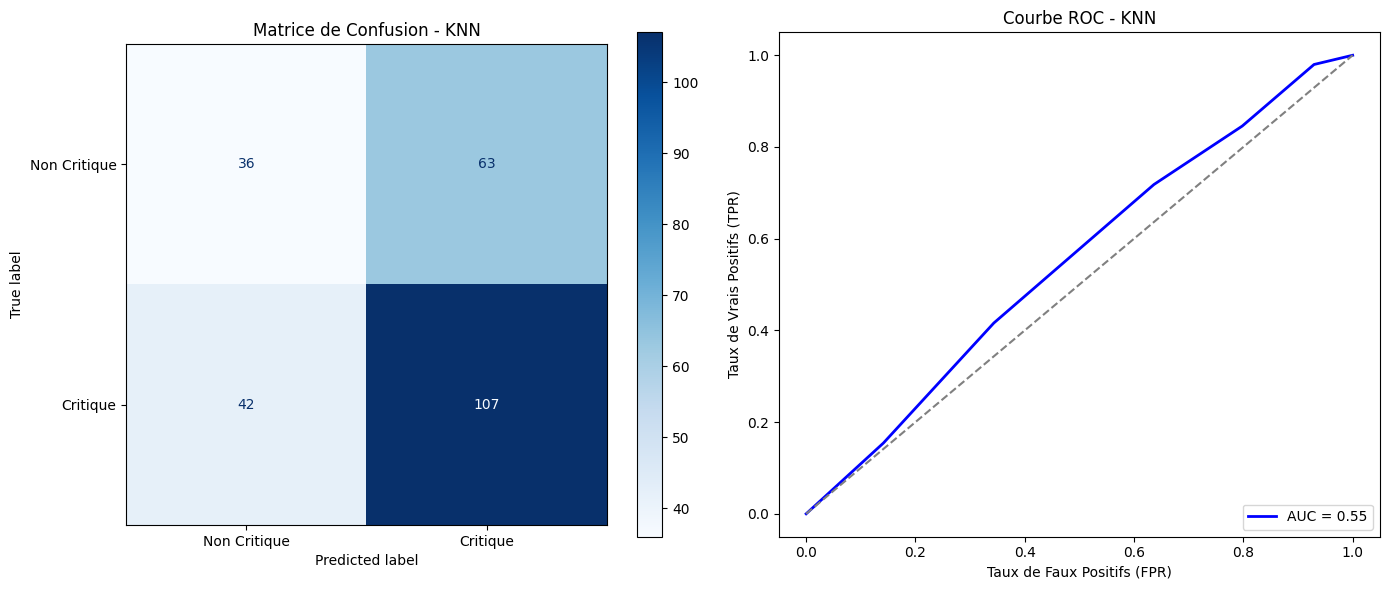

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Prédictions sur les données de test
y_pred_knn = knn.predict(X_test_scaled)

# Rapport de classification
print("\n🔹 KNN Report:\n", classification_report(y_test, y_pred_knn))

# Matrice de confusion et courbe ROC
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Matrice de confusion
ConfusionMatrixDisplay(conf_matrix_knn, display_labels=['Non Critique', 'Critique']).plot(cmap='Blues', ax=ax[0])
ax[0].set_title('Matrice de Confusion - KNN')

# Courbe ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

ax[1].plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'AUC = {roc_auc_knn:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('Courbe ROC - KNN')
ax[1].set_xlabel('Taux de Faux Positifs (FPR)')
ax[1].set_ylabel('Taux de Vrais Positifs (TPR)')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

